
--- Historical Data Summary ---
       Annual_Return
count      98.000000
mean        0.080868
std         0.190266
min        -0.470700
25%        -0.058175
50%         0.115850
75%         0.227925
max         0.465900
Loaded 98 years of historical returns.

Starting 5000 Monte Carlo trials...

--- Simulation Results ---
Total Trials: 5000
Failed Trials: 503
Success Rate (Portfolio > $0): 89.94%
Median (50th Percentile) Final Value: $23,506,528.25
10th Percentile Final Value (Poor Outcome): $0.00
90th Percentile Final Value (Great Outcome): $146,631,999.91


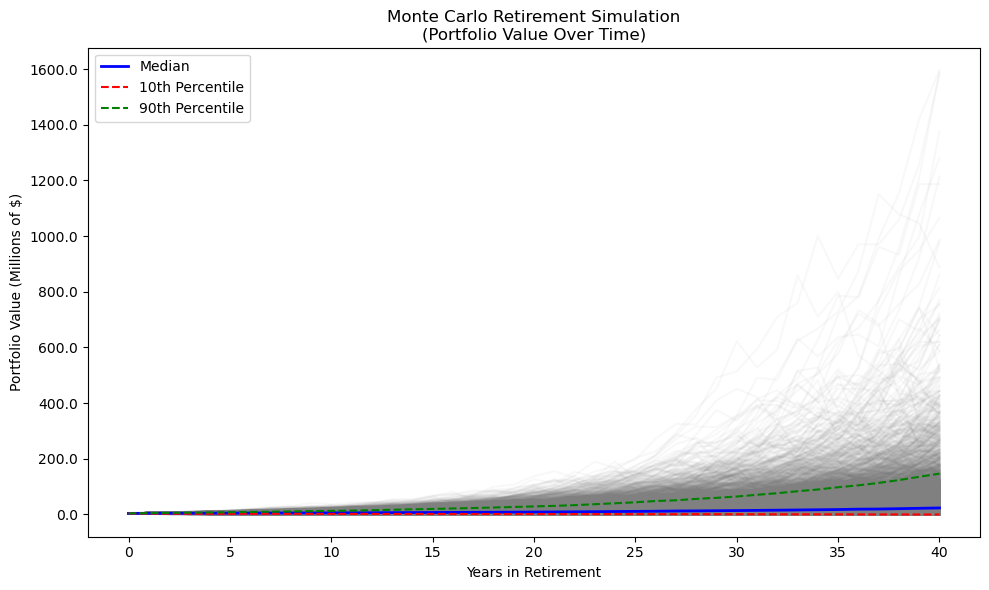

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker  

# Config/Assumptions
NUM_TRIALS = 5000
RETIREMENT_YEARS = 40
INITIAL_PORTFOLIO = 4000000
ANNUAL_WITHDRAWAL_RATE = 0.03

# Load Historical Data

historical_returns = pd.read_csv("Annual_Return.csv")

# Clean and prepare the data
historical_returns['Annual_Return'] = (
    historical_returns['Annual_Return']
    .astype(str)
    .str.replace('%', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
)

# Convert to numeric
historical_returns['Annual_Return'] = pd.to_numeric(
    historical_returns['Annual_Return'], errors='coerce'
)

# Drop invalid rows
historical_returns = historical_returns.dropna(subset=['Annual_Return'])

# Convert to decimal form
if historical_returns['Annual_Return'].abs().max() > 1.0:
    historical_returns['Annual_Return'] = historical_returns['Annual_Return'] / 100.0

# Display summary of data
print("\n--- Historical Data Summary ---")
print(historical_returns.describe())
print(f"Loaded {len(historical_returns)} years of historical returns.\n")

# Convert to array for faster sampling
historical_returns_array = historical_returns['Annual_Return'].values

# Monte Carlo Simulation
# Store full portfolio paths for all trials
portfolio_paths = np.zeros((NUM_TRIALS, RETIREMENT_YEARS + 1))

failure_count = 0
print(f"Starting {NUM_TRIALS} Monte Carlo trials...\n")

for trial in range(NUM_TRIALS):
    portfolio = INITIAL_PORTFOLIO
    annual_withdrawal = INITIAL_PORTFOLIO * ANNUAL_WITHDRAWAL_RATE
    portfolio_paths[trial, 0] = portfolio  # starting value

    random_return_sequence = np.random.choice(
        historical_returns_array,
        size=RETIREMENT_YEARS,
        replace=True
    )

    for year in range(RETIREMENT_YEARS):
        portfolio *= (1 + random_return_sequence[year])
        portfolio -= annual_withdrawal

        if portfolio <= 0:
            portfolio = 0
            failure_count += 1
            # Fill the rest of this trial’s years with zero
            portfolio_paths[trial, year + 1:] = 0
            break

        portfolio_paths[trial, year + 1] = portfolio

# Analyze Results
final_portfolio_values = portfolio_paths[:, -1]
success_rate = 1 - (failure_count / NUM_TRIALS)
median_value = np.median(final_portfolio_values)
p10 = np.percentile(final_portfolio_values, 10)
p90 = np.percentile(final_portfolio_values, 90)

print("--- Simulation Results ---")
print(f"Total Trials: {NUM_TRIALS}")
print(f"Failed Trials: {failure_count}")
print(f"Success Rate (Portfolio > $0): {success_rate:.2%}")
print(f"Median (50th Percentile) Final Value: ${median_value:,.2f}")
print(f"10th Percentile Final Value (Poor Outcome): ${p10:,.2f}")
print(f"90th Percentile Final Value (Great Outcome): ${p90:,.2f}")

# Visualization

years = np.arange(RETIREMENT_YEARS + 1)

plt.figure(figsize=(10, 6))
plt.plot(years, portfolio_paths.T, color='gray', alpha=0.05)

# Add median and key percentiles
median_path = np.median(portfolio_paths, axis=0)
p10_path = np.percentile(portfolio_paths, 10, axis=0)
p90_path = np.percentile(portfolio_paths, 90, axis=0)

plt.plot(years, median_path, color='blue', linewidth=2, label='Median')
plt.plot(years, p10_path, color='red', linestyle='--', linewidth=1.5, label='10th Percentile')
plt.plot(years, p90_path, color='green', linestyle='--', linewidth=1.5, label='90th Percentile')

plt.title("Monte Carlo Retirement Simulation\n(Portfolio Value Over Time)")
plt.xlabel("Years in Retirement")
plt.ylabel("Portfolio Value (Millions of $)")
plt.legend()

# Format y-axis to millions
plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}')
)

plt.tight_layout()
plt.show()
